In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 날씨 데이터 불러오기

In [2]:
# whether csv read, 일시를 index로 넣고 datetime 형태로 변환함
whether = pd.read_csv('./data/Whether.csv', encoding='euc-kr', parse_dates=['일시'], index_col='일시')
# 강수량, 적설이 null인 경우 모두 0으로 바꿈
whether = whether.fillna(0)
# 일시의 freq을 hour로 변경
whether.index.freq = 'h'

'''
데이터가 누락된 시간을 확인하기 위한 부분 (파일로 받은 경우)
API로 받는 경우 날짜는 있지만 모든 데이터가 Null값이기 때문에 해당 조건으로 수정해야 할 것으로 보임

j = whether.index[0]
for i in whether.index:
    if i != j + pd.Timedelta("1 hour"):
        print(j, i)
    j = i
'''
# 지점코드, 지점명을 없앰
whether = whether.iloc[:, [2,3,4,5,6]]
whether

,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm)
일시,,,,,
2020-10-01 00:00:00,17.3,0.0,0.2,92.0,0.0
2020-10-01 01:00:00,16.8,0.0,0.5,94.0,0.0
2020-10-01 02:00:00,16.9,0.0,1.1,93.0,0.0
2020-10-01 03:00:00,16.8,0.0,0.4,94.0,0.0
2020-10-01 04:00:00,16.1,0.0,0.1,95.0,0.0
...,...,...,...,...,...
2022-10-01 19:00:00,21.1,0.0,0.1,54.0,0.0
2022-10-01 20:00:00,19.6,0.0,0.6,63.0,0.0
2022-10-01 21:00:00,18.8,0.0,0.7,73.0,0.0


# 차량 데이터 불러오기 및 전처리

장비별, 일시별 구분  
입차 대수 - 출차 대수 = 현재 차량 대수  
한맥의 경우 FilePath로부터 입출차 시간 추출  
정기권 등 구분 X

In [4]:
def pretreatment(df):
    df['일시'] = pd.to_datetime(df['FilePath'].apply(lambda x: x[12:26]), format='%Y%m%d%H%M%S')
    df['일시'] = pd.to_datetime(df['일시']).apply(del_min_sec)
    df = df[['일시', 'FilePath', 'InOutDiv']]
    df = df.rename({'FilePath':'주차일련번호'}, axis=1)
    return df

def del_min_sec(x):
    return x.replace(minute=0, second=0)

car_normal = pd.read_csv('./data/일반차량.csv')
car_normal = pretreatment(car_normal)

car_ticket = pd.read_csv('./data/정기권차량.csv')
car_ticket = pretreatment(car_ticket)

hanmeak = pd.concat([car_normal, car_ticket]).sort_values('일시')
hanmeak_in = hanmeak[hanmeak['InOutDiv']==1].iloc[:,:2]
hanmeak_in = hanmeak_in.groupby('일시').count().reset_index().rename({'주차일련번호':'입차대수'}, axis=1)

hanmeak_out = hanmeak[hanmeak['InOutDiv']==2].iloc[:,:2]
hanmeak_out = hanmeak_out.groupby('일시').count().reset_index().rename({'주차일련번호':'출차대수'}, axis=1)

hanmeak_all = pd.merge(hanmeak_in, hanmeak_out, on='일시', how='outer').fillna(0).sort_values('일시').reset_index(drop=True)
hanmeak_all['입출차 차이'] = hanmeak_all['입차대수'] - hanmeak_all['출차대수']
hanmeak_all

,일시,입차대수,출차대수,입출차 차이
0,2020-10-01 04:00:00,1.0,0.0,1.0
1,2020-10-01 05:00:00,0.0,1.0,-1.0
2,2020-10-01 08:00:00,4.0,0.0,4.0
3,2020-10-01 09:00:00,2.0,0.0,2.0
4,2020-10-01 10:00:00,0.0,1.0,-1.0
...,...,...,...,...
12312,2022-10-01 19:00:00,4.0,11.0,-7.0
12313,2022-10-01 20:00:00,1.0,6.0,-5.0
12314,2022-10-01 21:00:00,1.0,3.0,-2.0
12315,2022-10-01 22:00:00,2.0,1.0,1.0


# 분석

2022년 9월 1일 ~ 2022년 10월 1일

In [5]:
from datetime import datetime
set_time = pd.date_range('20201001', '20221001230000', freq='h')

In [81]:
hanmeak_analysis = pd.DataFrame(index=set_time)
hanmeak_analysis = pd.merge(hanmeak_analysis, hanmeak_all, left_index=True, right_on='일시', how='left').fillna(0)
hanmeak_analysis = hanmeak_analysis.set_index('일시')
hanmeak_analysis['입출차 누계'] = hanmeak_analysis['입출차 차이'].cumsum()
# 누계가 음수인 경우, 최솟값만큼 기존에 차가 있었다고 가정함
if hanmeak_analysis['입출차 누계'].min() < 0:
    hanmeak_analysis['입출차 누계'] -= hanmeak_analysis['입출차 누계'].min()
hanmeak_analysis['월'] = hanmeak_analysis.index.month
hanmeak_analysis['일'] = hanmeak_analysis.index.day
hanmeak_analysis['시각'] = hanmeak_analysis.index.hour
hanmeak_analysis['Trend'] = range(2020, 2020+len(hanmeak_analysis))
hanmeak_analysis = pd.merge(hanmeak_analysis[['입출차 누계', '시각', 'Trend']], whether, left_index=True, right_index=True, how='left')
hanmeak_analysis.index.freq='h'
hanmeak_analysis

,입출차 누계,시각,Trend,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm)
일시,,,,,,,,
2020-10-01 00:00:00,5.0,0,2020,17.3,0.0,0.2,92.0,0.0
2020-10-01 01:00:00,5.0,1,2021,16.8,0.0,0.5,94.0,0.0
2020-10-01 02:00:00,5.0,2,2022,16.9,0.0,1.1,93.0,0.0
2020-10-01 03:00:00,5.0,3,2023,16.8,0.0,0.4,94.0,0.0
2020-10-01 04:00:00,6.0,4,2024,16.1,0.0,0.1,95.0,0.0
...,...,...,...,...,...,...,...,...
2022-10-01 19:00:00,166.0,19,19559,21.1,0.0,0.1,54.0,0.0
2022-10-01 20:00:00,161.0,20,19560,19.6,0.0,0.6,63.0,0.0
2022-10-01 21:00:00,159.0,21,19561,18.8,0.0,0.7,73.0,0.0


### LightGBM Regression

In [92]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb

train_hanmeak = hanmeak_analysis[hanmeak_analysis.index < datetime(2022, 10, 1)]
train_x = train_hanmeak.iloc[:, 1:]
train_y = train_hanmeak.iloc[:, 0]
train_set = lgb.Dataset(train_x, label = train_y) 

test_hanmeak = hanmeak_analysis[hanmeak_analysis.index >= datetime(2022, 10, 1)]
test_x = test_hanmeak.iloc[:, 1:]
test_y = test_hanmeak.iloc[:, 0]
test_set = lgb.Dataset(test_x, label = test_y) 

In [93]:
params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':1111}

In [94]:
model = lgb.train(params, train_set, 1000, test_set, verbose_eval=100, early_stopping_rounds=100)

C:\Users\kyw65\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\kyw65\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 821
[LightGBM] [Info] Number of data points in the train set: 17520, number of used features: 7
[LightGBM] [Info] Start training from score 123.162900
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 564.743
[200]	valid_0's l2: 203.29
[300]	valid_0's l2: 115.434
[400]	valid_0's l2: 83.8439
[500]	valid_0's l2: 70.5571
[600]	valid_0's l2: 63.5659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[700]	valid_0's l2: 63.2649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [95]:
predict_test = model.predict(test_x)

In [96]:
MAE = mean_absolute_error(test_y, predict_test)
MAE_per = sum(abs(test_y - predict_test)) / sum(test_y) * 100
print('MAE =', MAE)
print('MAE_per =', MAE_per)
RMSE = np.sqrt(mean_squared_error(test_y, predict_test))
RMSE_per = (np.sqrt(np.mean(np.square((test_y - predict_test) / test_y)))) * 100
print('RMSE =', RMSE)
print('RMSE(per) =', RMSE_per)

MAE = 6.955118902518869
MAE_per = 4.167861514618049
RMSE = 7.7362614625279305
RMSE(per) = 4.761350894196458


<AxesSubplot:xlabel='일시'>

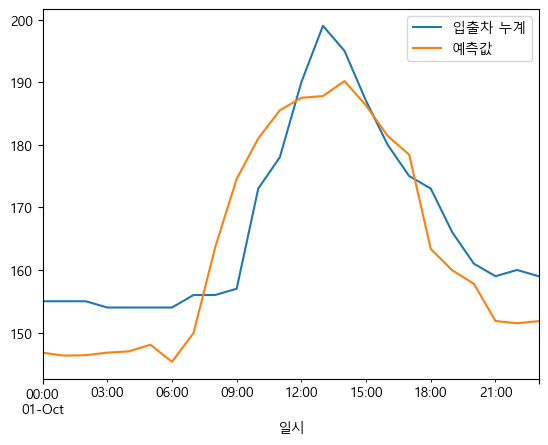

In [97]:
pd.concat([test_y, pd.Series(predict_test, index=test_y.index, name='예측값')], axis=1).plot()

In [83]:
pd.concat([test_y, pd.Series(predict_test, index=test_y.index, name='예측값')], axis=1)

,입출차 누계,예측값
일시,,
2022-10-01 00:00:00,155.0,146.784641
2022-10-01 01:00:00,155.0,146.314098
2022-10-01 02:00:00,155.0,146.380189
2022-10-01 03:00:00,154.0,146.793995
2022-10-01 04:00:00,154.0,146.995198
2022-10-01 05:00:00,154.0,148.057092
2022-10-01 06:00:00,154.0,145.320501
2022-10-01 07:00:00,156.0,149.934789
2022-10-01 08:00:00,156.0,163.585557
